In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


"""
frames = [train_data, test_data]

dataframe  = pd.concat(frames)
raw_data = dataframe.values
#dataframe.head()
#raw_data


# The last element contains the labels
labels = raw_data[:, -1]

#print(test_data.columns )

data = raw_data[:, 0:-1]
#print(data)


train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=34
)


min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]
"""

'\nframes = [train_data, test_data]\n\ndataframe  = pd.concat(frames)\nraw_data = dataframe.values\n#dataframe.head()\n#raw_data\n\n\n# The last element contains the labels\nlabels = raw_data[:, -1]\n\n#print(test_data.columns )\n\ndata = raw_data[:, 0:-1]\n#print(data)\n\n\ntrain_data, test_data, train_labels, test_labels = train_test_split(\n    data, labels, test_size=0.2, random_state=34\n)\n\n\nmin_val = tf.reduce_min(train_data)\nmax_val = tf.reduce_max(train_data)\n\ntrain_data = (train_data - min_val) / (max_val - min_val)\ntest_data = (test_data - min_val) / (max_val - min_val)\n\ntrain_data = tf.cast(train_data, tf.float32)\ntest_data = tf.cast(test_data, tf.float32)\n\ntrain_labels = train_labels.astype(bool)\ntest_labels = test_labels.astype(bool)\n\nnormal_train_data = train_data[train_labels]\nnormal_test_data = test_data[test_labels]\n\nanomalous_train_data = train_data[~train_labels]\nanomalous_test_data = test_data[~test_labels]\n'

In [10]:
train_data = pd.read_csv('eda_simple_classification/network_data_mod_train.csv')
test_data = pd.read_csv('eda_simple_classification/network_data_mod_test.csv')

train_data = train_data.values
test_data = test_data.values


In [11]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [14]:
train_data


<tf.Tensor: shape=(125973, 48), dtype=float32, numpy=
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 3.9691361e-07,
        0.0000000e+00, 7.9382717e-06],
       [7.9382717e-06, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 7.9382717e-06],
       [1.5876543e-05, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [9.9998415e-01, 0.0000000e+00, 0.0000000e+00, ..., 7.9382723e-08,
        0.0000000e+00, 7.9382717e-06],
       [9.9999207e-01, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 7.9382717e-06]], dtype=float32)>

In [ ]:
normal_train_data.columns

TensorShape([61644, 47])

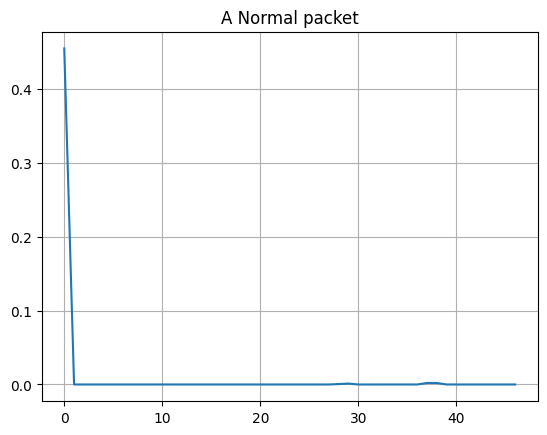

In [ ]:
plt.grid()
plt.plot(np.arange(47), normal_train_data[0])
plt.title("A Normal packet")
plt.show()

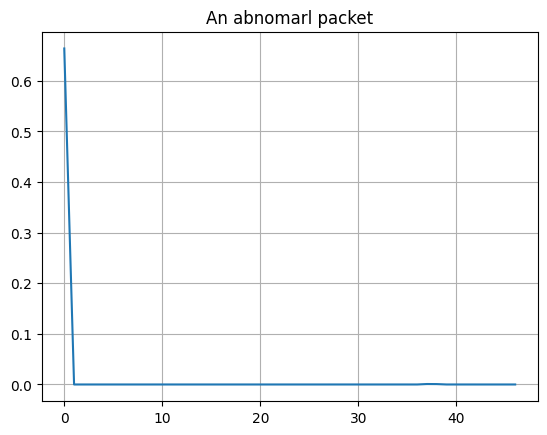

In [ ]:
plt.grid()
plt.plot(np.arange(47), anomalous_train_data[0])
plt.title("An abnomarl packet")
plt.show()

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(47, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=5000, batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/5000
121/121 [==============================] - 2s 4ms/step - loss: 0.2387 - val_loss: 0.0081
Epoch 2/5000
121/121 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 3/5000
121/121 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 4/5000
121/121 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 5/5000
121/121 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 6/5000
121/121 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 7/5000
121/121 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 8/5000
121/121 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 9/5000
121/121 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 10/5000
121/121 [==============================] - 0s 3ms/step - loss: 0.004

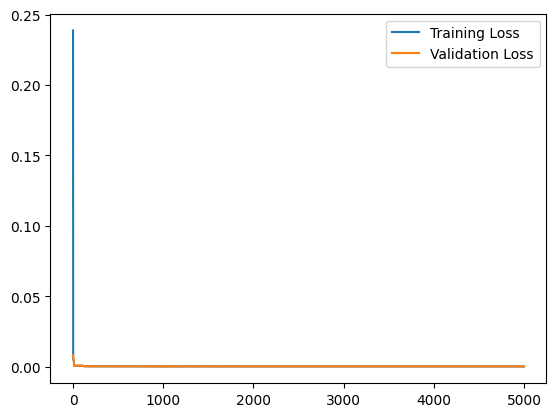

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

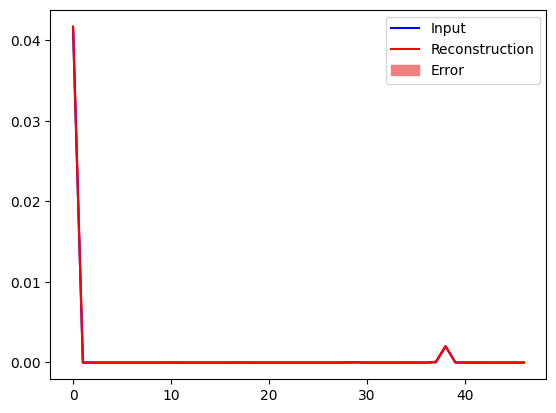

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(47), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

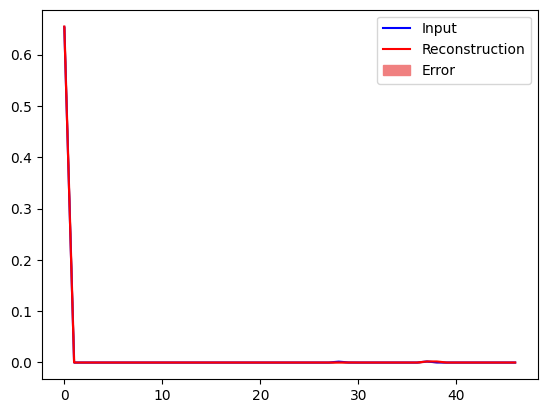

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(47), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

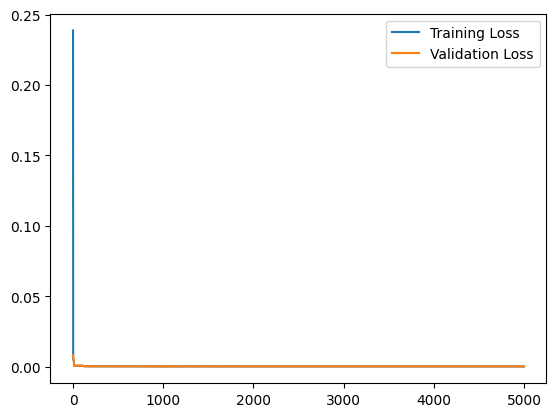

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

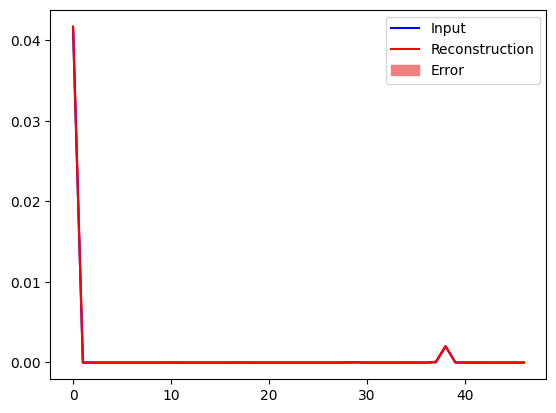

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(47), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

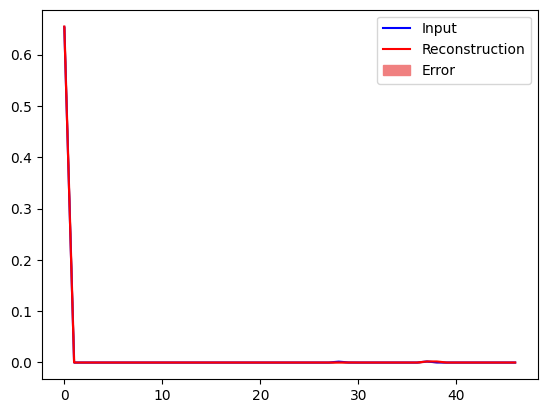

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(47), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

1927/1927 [==============================] - 3s 929us/step


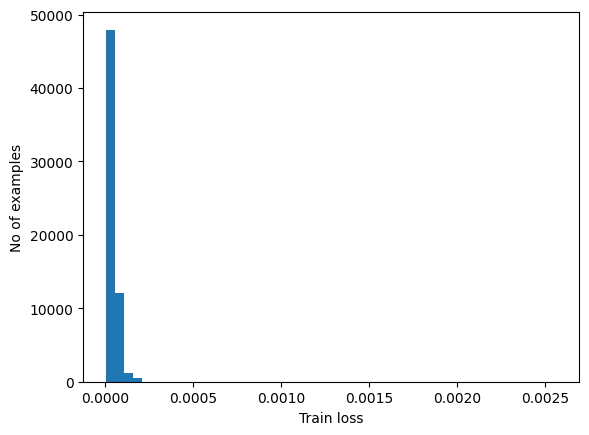

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  6.5457454e-05


In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.8008685698895771
Precision = 0.7618443549721472
Recall = 0.8963659961064244


In [ ]:
preds_01 = []
test_labels_01 = []
for item in preds:
  if item == True:
    preds_01.append(1)
  else:
    preds_01.append(0)

for item in test_labels:
  if item == True:
    test_labels_01.append(1)
  else:
    test_labels_01.append(0)

In [ ]:
print(preds_01)

[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 

In [ ]:
print(test_labels_01)

[0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 